In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("eoinamoore/historical-nba-data-and-player-box-scores")

print("Path to dataset files:", path)

c:\Users\nmall\nbaTopScorerProj\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\nmall\.cache\kagglehub\datasets\eoinamoore\historical-nba-data-and-player-box-scores\versions\375


In [ ]:
import pandas as pd

def load_and_process_data(file_path):
    # Load data from CSV file
    df = pd.read_csv("C:\\Users\\nmall\\.cache\\kagglehub\\datasets\\eoinamoore\\historical-nba-data-and-player-box-scores\\versions\\366\\" + file_path)
    
    # Display the first few rows of the dataframe
    print("Initial Data:")
    print(df.head())
    
    # Check for missing values
    missing_values = df.isnull().sum()
    print("\nMissing Values in Each Column:")
    print(missing_values)
    
    # Fill missing values with the mean of the column (for numerical columns)
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        df[column].fillna(df[column].mean(), inplace=True)
    
    # Convert categorical columns to category type
    for column in df.select_dtypes(include=['object']).columns:
        df[column] = df[column].astype('string')
    
    # Display the processed dataframe info
    print("\nProcessed Data Info:")
    print(df.info())
    
    return df
gamesInfo = load_and_process_data('Games.csv')
playersStats = load_and_process_data('PlayerStatistics.csv')
TeamStatistics = load_and_process_data('TeamStatistics.csv')

C:\Users\nmall\AppData\Local\Temp\ipykernel_32812\1723445430.py:5: DtypeWarning: Columns (12,14,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:\\Users\\nmall\\.cache\\kagglehub\\datasets\\eoinamoore\\historical-nba-data-and-player-box-scores\\versions\\366\\" + file_path)
C:\Users\nmall\AppData\Local\Temp\ipykernel_32812\1723445430.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)
C:\Users\nmall\AppData\Local\Tem

Initial Data:
     gameId      gameDateTimeEst hometeamCity hometeamName  hometeamId  \
0  22500739  2026-02-05 22:00:00      Phoenix         Suns  1610612756   
1  22500740  2026-02-05 22:00:00  Los Angeles       Lakers  1610612747   
2  22500738  2026-02-05 20:30:00       Dallas    Mavericks  1610612742   
3  22500737  2026-02-05 20:00:00      Houston      Rockets  1610612745   
4  22500736  2026-02-05 19:30:00      Toronto      Raptors  1610612761   

   awayteamCity awayteamName  awayteamId  homeScore  awayScore  ...  \
0  Golden State     Warriors  1610612744         97        101  ...   
1  Philadelphia        76ers  1610612755        119        115  ...   
2   San Antonio        Spurs  1610612759        123        135  ...   
3     Charlotte      Hornets  1610612766         99        109  ...   
4       Chicago        Bulls  1610612741        123        107  ...   

   gameSubtype gameLabel gameSubLabel seriesGameNumber attendance  arenaId  \
0          NaN       NaN          Na

C:\Users\nmall\AppData\Local\Temp\ipykernel_32812\1723445430.py:5: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:\\Users\\nmall\\.cache\\kagglehub\\datasets\\eoinamoore\\historical-nba-data-and-player-box-scores\\versions\\366\\" + file_path)


Initial Data:
    firstName   lastName  personId    gameId      gameDateTimeEst  \
0       Royce    O'Neale   1626220  22500739  2026-02-05 22:00:00   
1        Gary  Payton II   1627780  22500739  2026-02-05 22:00:00   
2      Dillon     Brooks   1628415  22500739  2026-02-05 22:00:00   
3     Grayson      Allen   1628960  22500739  2026-02-05 22:00:00   
4  De'Anthony     Melton   1629001  22500739  2026-02-05 22:00:00   

  playerteamCity playerteamName opponentteamCity opponentteamName  \
0        Phoenix           Suns     Golden State         Warriors   
1   Golden State       Warriors          Phoenix             Suns   
2        Phoenix           Suns     Golden State         Warriors   
3        Phoenix           Suns     Golden State         Warriors   
4   Golden State       Warriors          Phoenix             Suns   

         gameType  ... threePointersPercentage freeThrowsAttempted  \
0  Regular Season  ...                   0.500                 0.0   
1  Regular Seaso

C:\Users\nmall\AppData\Local\Temp\ipykernel_32812\1723445430.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)



Processed Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650096 entries, 0 to 1650095
Data columns (total 35 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   firstName                1650096 non-null  string 
 1   lastName                 1650096 non-null  string 
 2   personId                 1650096 non-null  int64  
 3   gameId                   1650096 non-null  int64  
 4   gameDateTimeEst          1650096 non-null  string 
 5   playerteamCity           1650096 non-null  string 
 6   playerteamName           1650096 non-null  string 
 7   opponentteamCity         1650096 non-null  string 
 8   opponentteamName         1650096 non-null  string 
 9   gameType                 1650046 non-null  string 
 10  gameLabel                95271 non-null    string 
 11  gameSubLabel             6364 non-null     string 
 12  seriesGameNumber         1650096 non-null  float64
 13  win                 

C:\Users\nmall\AppData\Local\Temp\ipykernel_32812\1723445430.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)


In [4]:
# TeamStatistics
# Add column representing the season for each row in RegSeasonPlayerStats
teamAverageBySeason = TeamStatistics.copy()
teamAverageBySeason['month'] = teamAverageBySeason['gameDateTimeEst'].str[5:7]
teamAverageBySeason['year'] = teamAverageBySeason['gameDateTimeEst'].str[0:4]
teamAverageBySeason['day'] = teamAverageBySeason['gameDateTimeEst'].str[8:10]
# create a datetime column based on the year, month, and day columns
teamAverageBySeason['gameDate'] = pd.to_datetime(teamAverageBySeason['year'] + '-' + teamAverageBySeason['month'] + '-' + teamAverageBySeason['day'])
# Create a season column based on the year and month
teamAverageBySeason['season'] = teamAverageBySeason.apply(lambda row: f"{row['year']}-{int(row['year']) + 1}" if row['month'] >= '10' else f"{int(row['year']) - 1}-{row['year']}", axis=1)

In [5]:
teamAverageBySeason.drop(columns=['month', 'year', 'day', 'gameDateTimeEst'], inplace=True)
teamAverageBySeason = teamAverageBySeason.groupby(["gameId", "season", "teamName"])
teamAverageBySeason.head(5)

,gameId,teamCity,teamName,teamId,opponentTeamCity,opponentTeamName,opponentTeamId,home,win,teamScore,...,pointsFromTurnovers,pointsInThePaint,pointsSecondChance,timesTied,timeoutsRemaining,seasonWins,seasonLosses,coachId,gameDate,season
0,22500739,Golden State,Warriors,1610612744,Phoenix,Suns,1610612756,0,1.0,101,...,13.000000,22.000000,13.000000,7.000000,0.000000,28.000000,24.000000,NaN,2026-02-05,2025-2026
1,22500740,Los Angeles,Lakers,1610612747,Philadelphia,76ers,1610612755,1,1.0,119,...,17.000000,66.000000,11.000000,1.000000,0.000000,31.000000,19.000000,NaN,2026-02-05,2025-2026
2,22500740,Philadelphia,76ers,1610612755,Los Angeles,Lakers,1610612747,0,0.0,115,...,24.000000,66.000000,5.000000,1.000000,0.000000,29.000000,22.000000,NaN,2026-02-05,2025-2026
3,22500739,Phoenix,Suns,1610612756,Golden State,Warriors,1610612744,1,0.0,97,...,14.000000,32.000000,14.000000,7.000000,0.000000,31.000000,21.000000,NaN,2026-02-05,2025-2026
4,22500738,Dallas,Mavericks,1610612742,San Antonio,Spurs,1610612759,1,0.0,123,...,6.000000,54.000000,10.000000,4.000000,1.000000,19.000000,32.000000,NaN,2026-02-05,2025-2026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145435,24600076,New York,Knicks,1610612752,Philadelphia,Warriors,1610612744,0,0.0,51,...,17.754283,48.917493,14.512399,4.969342,0.461452,16.055005,16.064698,NaN,1946-12-05,1946-1947
145436,24600063,Philadelphia,Warriors,1610612744,New York,Knicks,1610612752,0,0.0,60,...,17.754283,48.917493,14.512399,4.969342,0.461452,16.055005,16.064698,NaN,1946-11-30,1946-1947
145437,24600063,New York,Knicks,1610612752,Philadelphia,Warriors,1610612744,1,1.0,64,...,17.754283,48.917493,14.512399,4.969342,0.461452,16.055005,16.064698,NaN,1946-11-30,1946-1947
145438,24600052,Boston,Celtics,1610612738,Philadelphia,Warriors,1610612744,0,0.0,54,...,17.754283,48.917493,14.512399,4.969342,0.461452,16.055005,16.064698,NaN,1946-11-26,1946-1947


In [6]:
playersStats.head(10)

,firstName,lastName,personId,gameId,gameDateTimeEst,playerteamCity,playerteamName,opponentteamCity,opponentteamName,gameType,...,threePointersPercentage,freeThrowsAttempted,freeThrowsMade,freeThrowsPercentage,reboundsDefensive,reboundsOffensive,reboundsTotal,foulsPersonal,turnovers,plusMinusPoints
0,Royce,O'Neale,1626220,22500739,2026-02-05 22:00:00,Phoenix,Suns,Golden State,Warriors,Regular Season,...,0.500,0.0,0.0,0.000,1.0,0.0,1.0,1.0,1.0,-5.0
1,Gary,Payton II,1627780,22500739,2026-02-05 22:00:00,Golden State,Warriors,Phoenix,Suns,Regular Season,...,0.500,0.0,0.0,0.000,5.0,3.0,8.0,1.0,0.0,4.0
2,Dillon,Brooks,1628415,22500739,2026-02-05 22:00:00,Phoenix,Suns,Golden State,Warriors,Regular Season,...,0.333,3.0,2.0,0.667,5.0,1.0,6.0,3.0,2.0,-6.0
3,Grayson,Allen,1628960,22500739,2026-02-05 22:00:00,Phoenix,Suns,Golden State,Warriors,Regular Season,...,0.385,2.0,2.0,1.000,4.0,1.0,5.0,1.0,3.0,4.0
4,De'Anthony,Melton,1629001,22500739,2026-02-05 22:00:00,Golden State,Warriors,Phoenix,Suns,Regular Season,...,0.222,4.0,3.0,0.750,2.0,0.0,2.0,1.0,2.0,21.0
5,Pat,Spencer,1630311,22500739,2026-02-05 22:00:00,Golden State,Warriors,Phoenix,Suns,Regular Season,...,0.600,2.0,2.0,1.000,5.0,1.0,6.0,2.0,4.0,-3.0
6,Moses,Moody,1630541,22500739,2026-02-05 22:00:00,Golden State,Warriors,Phoenix,Suns,Regular Season,...,0.286,0.0,0.0,0.000,8.0,0.0,8.0,1.0,1.0,4.0
7,Isaiah,Livers,1630587,22500739,2026-02-05 22:00:00,Phoenix,Suns,Golden State,Warriors,Regular Season,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,1.0,0.0,-8.0
8,Gui,Santos,1630611,22500739,2026-02-05 22:00:00,Golden State,Warriors,Phoenix,Suns,Regular Season,...,0.500,5.0,3.0,0.600,4.0,0.0,4.0,2.0,4.0,2.0
9,Jordan,Goodwin,1630692,22500739,2026-02-05 22:00:00,Phoenix,Suns,Golden State,Warriors,Regular Season,...,0.333,0.0,0.0,0.000,2.0,0.0,2.0,3.0,0.0,7.0


In [7]:
print("Stats go from", playersStats['gameDateTimeEst'].min(), "to", playersStats['gameDateTimeEst'].max())

Stats go from 1946-11-26 19:00:00 to 2026-02-05 22:00:00


In [8]:
# count the values of gametype in PlayerStats
playersStats['gameType'].value_counts(dropna=False)

gameType
Regular Season        1490437
Playoffs                99840
Preseason               57118
NBA Emirates Cup         1759
Play-in Tournament        829
<NA>                       50
Emirates NBA Cup           30
NBA Cup                    28
in-season-knockout          5
Name: count, dtype: Int64

In [9]:
# take a look at what rows have gameType as null
playersStats[playersStats['gameType'].isnull()].tail(10)

,firstName,lastName,personId,gameId,gameDateTimeEst,playerteamCity,playerteamName,opponentteamCity,opponentteamName,gameType,...,threePointersPercentage,freeThrowsAttempted,freeThrowsMade,freeThrowsPercentage,reboundsDefensive,reboundsOffensive,reboundsTotal,foulsPersonal,turnovers,plusMinusPoints
11651,AJ,Johnson,1642358,22500334,2025-12-04 14:00:00,Washington,Wizards,Boston,Celtics,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17427,Dorian,Finney-Smith,1627827,22500160,2025-11-03 20:00:00,Houston,Rockets,Dallas,Mavericks,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17428,Fred,VanVleet,1627832,22500160,2025-11-03 20:00:00,Houston,Rockets,Dallas,Mavericks,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17444,JD,Davison,1631120,22500160,2025-11-03 20:00:00,Houston,Rockets,Dallas,Mavericks,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17446,Dereck,Lively II,1641726,22500160,2025-11-03 20:00:00,Dallas,Mavericks,Houston,Rockets,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17448,Isaiah,Crawford,1642384,22500160,2025-11-03 20:00:00,Houston,Rockets,Dallas,Mavericks,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17450,Miles,Kelly,1642939,22500160,2025-11-03 20:00:00,Dallas,Mavericks,Houston,Rockets,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17454,Kyrie,Irving,202681,22500160,2025-11-03 20:00:00,Dallas,Mavericks,Houston,Rockets,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17456,Anthony,Davis,203076,22500160,2025-11-03 20:00:00,Dallas,Mavericks,Houston,Rockets,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17459,Dante,Exum,203957,22500160,2025-11-03 20:00:00,Dallas,Mavericks,Houston,Rockets,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Any player stats with a null gameType are regular season games so we'll adjust accordingly
playersStats['gameType'].fillna('Regular Season', inplace=True)
playersStats['gameType'].value_counts(dropna=False)

C:\Users\nmall\AppData\Local\Temp\ipykernel_32812\1021499322.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  playersStats['gameType'].fillna('Regular Season', inplace=True)


gameType
Regular Season        1490487
Playoffs                99840
Preseason               57118
NBA Emirates Cup         1759
Play-in Tournament        829
Emirates NBA Cup           30
NBA Cup                    28
in-season-knockout          5
Name: count, dtype: Int64

In [11]:
RegSeasonPlayerStats = playersStats[playersStats['gameType'] == 'Regular Season']
RegSeasonPlayerStats.dtypes

firstName                  string[python]
lastName                   string[python]
personId                            int64
gameId                              int64
gameDateTimeEst            string[python]
playerteamCity             string[python]
playerteamName             string[python]
opponentteamCity           string[python]
opponentteamName           string[python]
gameType                   string[python]
gameLabel                  string[python]
gameSubLabel               string[python]
seriesGameNumber                  float64
win                               float64
home                                int64
numMinutes                        float64
points                            float64
assists                           float64
blocks                            float64
steals                            float64
fieldGoalsAttempted               float64
fieldGoalsMade                    float64
fieldGoalsPercentage              float64
threePointersAttempted            

In [12]:
# Add column representing the season for each row in RegSeasonPlayerStats
RegSeasonPlayerStats['month'] = RegSeasonPlayerStats['gameDateTimeEst'].str[5:7]
RegSeasonPlayerStats['year'] = RegSeasonPlayerStats['gameDateTimeEst'].str[0:4]
RegSeasonPlayerStats['day'] = RegSeasonPlayerStats['gameDateTimeEst'].str[8:10]
# create a datetime column based on the year, month, and day columns
RegSeasonPlayerStats['gameDate'] = pd.to_datetime(RegSeasonPlayerStats['year'] + '-' + RegSeasonPlayerStats['month'] + '-' + RegSeasonPlayerStats['day'])

RegSeasonPlayerStats["fullName"] = RegSeasonPlayerStats["firstName"] + " " + RegSeasonPlayerStats["lastName"]

# Create a season column based on the year and month
RegSeasonPlayerStats['season'] = RegSeasonPlayerStats.apply(lambda row: f"{row['year']}-{int(row['year']) + 1}" if row['month'] >= '10' else f"{int(row['year']) - 1}-{row['year']}", axis=1)
RegSeasonPlayerStats['season'].value_counts(dropna=False)

C:\Users\nmall\AppData\Local\Temp\ipykernel_32812\1207554893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RegSeasonPlayerStats['month'] = RegSeasonPlayerStats['gameDateTimeEst'].str[5:7]
C:\Users\nmall\AppData\Local\Temp\ipykernel_32812\1207554893.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RegSeasonPlayerStats['year'] = RegSeasonPlayerStats['gameDateTimeEst'].str[0:4]
C:\Users\nmall\AppData\Local\Temp\ipykernel_32812\1207554893.py:4: SettingWithCopyWarning: 
A value is trying to be set on a 

season
2024-2025    32519
2016-2017    31564
2022-2023    31542
2015-2016    31423
2014-2015    31412
             ...  
1950-1951     3726
1949-1950     2464
1948-1949     1609
1947-1948      458
1946-1947      357
Name: count, Length: 80, dtype: int64

In [13]:
# check for duplicates in RegSeasonPlayerStats
RegSeasonPlayerStats.duplicated().sum()

np.int64(0)

In [14]:
# Aggregate the data by season, player, and total games played, points scored, and points per game
# also add columns for the player's average points per win and average points per loss
season_player_stats = RegSeasonPlayerStats.groupby(['season', 'personId']).agg(
    fullName=('fullName', 'first'),
    team=('playerteamName', 'first'),
    player_games_played=('gameId', 'nunique'),
    total_points_scored=('points', 'sum'),
    points_per_game=('points', 'mean'),
    avg_points_per_win=('points', lambda x: x[RegSeasonPlayerStats.loc[x.index, 'win'] == 1].mean()),
    avg_points_per_loss=('points', lambda x: x[RegSeasonPlayerStats.loc[x.index, 'win'] == 0].mean()),
    fg_percentage_per_win=('fieldGoalsPercentage', lambda x: x[RegSeasonPlayerStats.loc[x.index, 'win'] == 1].mean()),
    fg_percentage_per_loss=('fieldGoalsPercentage', lambda x: x[RegSeasonPlayerStats.loc[x.index, 'win'] == 0].mean())
).reset_index()
season_player_stats.tail(10)

,season,personId,fullName,team,player_games_played,total_points_scored,points_per_game,avg_points_per_win,avg_points_per_loss,fg_percentage_per_win,fg_percentage_per_loss
25422,2025-2026,1642950,Lachlan Olbrich,Bulls,22,17.0,0.772727,0.285714,1.000000,0.142857,0.115533
25423,2025-2026,1642954,Will Richard,Warriors,52,320.0,6.153846,6.750000,5.458333,0.479464,0.331958
25424,2025-2026,1642959,Chris Youngblood,Thunder,50,65.0,1.300000,1.333333,1.181818,0.179795,0.143909
25425,2025-2026,1642962,Drake Powell,Nets,44,236.0,5.363636,5.727273,5.242424,0.449727,0.330576
25426,2025-2026,1642964,Brooks Barnhizer,Thunder,30,45.0,1.500000,1.260870,2.285714,0.304348,0.190429
25427,2025-2026,1643007,Taelon Peter,Pacers,33,44.0,1.333333,0.500000,1.518519,0.083333,0.141519
25428,2025-2026,1643018,LJ Cryer,Warriors,5,6.0,1.200000,3.000000,0.000000,0.416500,0.000000
25429,2025-2026,1643024,Chris Manon,Lakers,8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25430,2025-2026,1643052,Chaney Johnson,Nets,2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25431,2025-2026,1643141,Jahmyl Telfort,Clippers,13,1.0,0.076923,0.000000,0.111111,0.000000,0.000000


In [21]:
# Get one row per team per game
game_wins = RegSeasonPlayerStats[RegSeasonPlayerStats['win'] == 1].groupby(['gameId', 'playerteamName', 'season']).agg(
    win=('win', 'first'),  # All players on winning team have win=1
).reset_index()
game_wins.head(5)
# Then count wins per team per season
game_wins = game_wins.groupby(['playerteamName', 'season']).agg(
    total_team_wins=('win', 'sum'),
).reset_index()

game_wins[game_wins['season'] == '2024-2025'].sort_values(by='total_team_wins', ascending=False).head(10)

,playerteamName,season,total_team_wins
1482,Thunder,2024-2025,68.0
289,Cavaliers,2024-2025,64.0
369,Celtics,2024-2025,61.0
784,Knicks,2024-2025,51.0
1291,Rockets,2024-2025,51.0
1059,Nuggets,2024-2025,50.0
1109,Pacers,2024-2025,50.0
417,Clippers,2024-2025,49.0
862,Lakers,2024-2025,49.0
1519,Timberwolves,2024-2025,49.0


In [16]:
# join the total wins per team per season to the season_player_stats dataframe
season_player_stats = season_player_stats.merge(game_wins, left_on=['team', 'season'], right_on=['playerteamName', 'season'], how='left')
season_player_stats.drop(columns=['playerteamName'], inplace=True)

In [17]:
# create a dataframe of the best scorer for each team for each season
topTeamScorers = season_player_stats.loc[season_player_stats.groupby(['season', 'team'])['points_per_game'].idxmax()]
topTeamScorers["ppg_gap"] = topTeamScorers["avg_points_per_win"] - topTeamScorers["avg_points_per_loss"]
topTeamScorers.tail(10)

,season,personId,fullName,team,player_games_played,total_points_scored,points_per_game,avg_points_per_win,avg_points_per_loss,fg_percentage_per_win,fg_percentage_per_loss,gameId,win,ppg_gap
983302,2025-2026,1630595,Cade Cunningham,Pistons,45,1119.0,24.866667,24.303030,26.416667,0.474909,0.405667,22500017,1.0,-2.113636
978407,2025-2026,1627742,Brandon Ingram,Raptors,51,1130.0,22.156863,21.566667,23.000000,0.465667,0.482905,22500022,1.0,-1.433333
976448,2025-2026,201142,Kevin Durant,Rockets,47,1224.0,26.042553,25.571429,26.736842,0.522679,0.499105,22500012,1.0,-1.165414
985565,2025-2026,1641705,Victor Wembanyama,Spurs,37,894.0,24.162162,25.160000,22.083333,0.565800,0.421000,22500004,1.0,3.076667
978120,2025-2026,1626164,Devin Booker,Suns,41,1043.0,25.439024,23.884615,28.133333,0.460038,0.459000,22500025,1.0,-4.248718
979788,2025-2026,1628983,Shai Gilgeous-Alexander,Thunder,49,1558.0,31.795918,32.052632,30.909091,0.583105,0.518455,22500001,1.0,1.143541
981386,2025-2026,1630162,Anthony Edwards,Timberwolves,42,1246.0,29.666667,27.230769,33.625000,0.479077,0.505187,22500036,1.0,-6.394231
981455,2025-2026,1630166,Deni Avdija,Trail Blazers,51,1121.0,21.980392,24.739130,19.714286,0.445609,0.360393,22500026,1.0,5.024845
976709,2025-2026,201939,Stephen Curry,Warriors,39,1061.0,27.205128,26.173913,28.687500,0.461261,0.440875,22500002,1.0,-2.513587
987209,2025-2026,1642259,Alex Sarr,Wizards,41,692.0,16.878049,19.363636,15.966667,0.527455,0.461367,22500057,1.0,3.396970


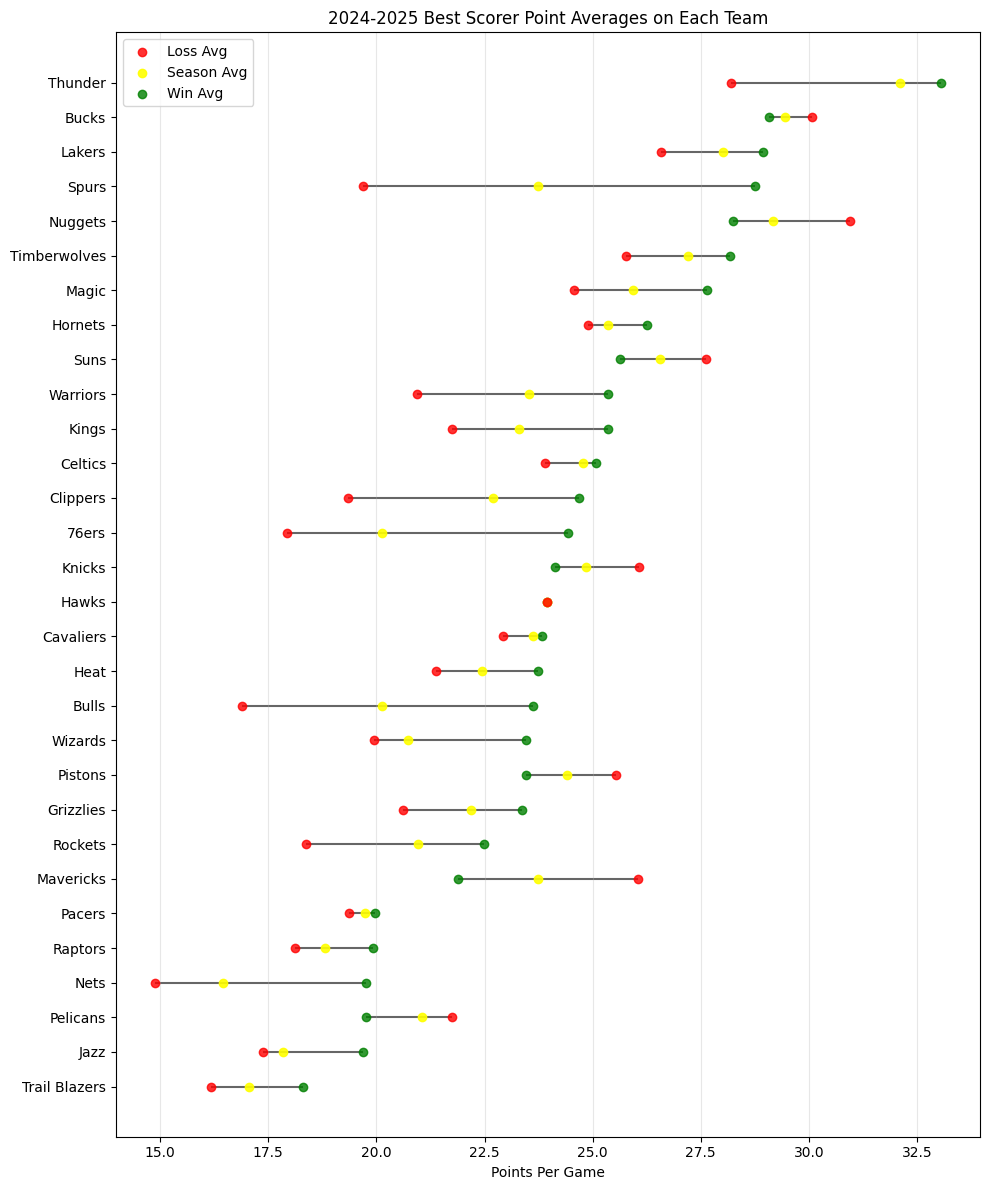

In [18]:
import matplotlib.pyplot as plt

plot_df = topTeamScorers[topTeamScorers['season'] == '2024-2025'].copy()
plot_df = plot_df.sort_values("avg_points_per_win", ascending=True)

plt.figure(figsize=(10, 12))


# Loss averages (RED)
plt.scatter(
    plot_df["avg_points_per_loss"],
    plot_df["team"],
    color="red",
    label="Loss Avg",
    alpha=0.8,
    zorder=4
)

# Season averages
plt.scatter(
    plot_df["points_per_game"],
    plot_df["team"],
    color="yellow",
    label="Season Avg",
    alpha=0.9,
    zorder=3 
)

# Win averages
plt.scatter(
    plot_df["avg_points_per_win"],
    plot_df["team"],
    color="green",
    label="Win Avg",
    alpha=0.8,
    zorder=2 
)
# Black connecting line (loss -> win)
plt.hlines(
    y=plot_df["team"],
    xmin=plot_df["avg_points_per_loss"],
    xmax=plot_df["avg_points_per_win"],
    color="black",
    alpha=0.6,
    linewidth=1.5,
    zorder=1
)

plt.xlabel("Points Per Game")
plt.title("2024-2025 Best Scorer Point Averages on Each Team")
plt.legend()
plt.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()


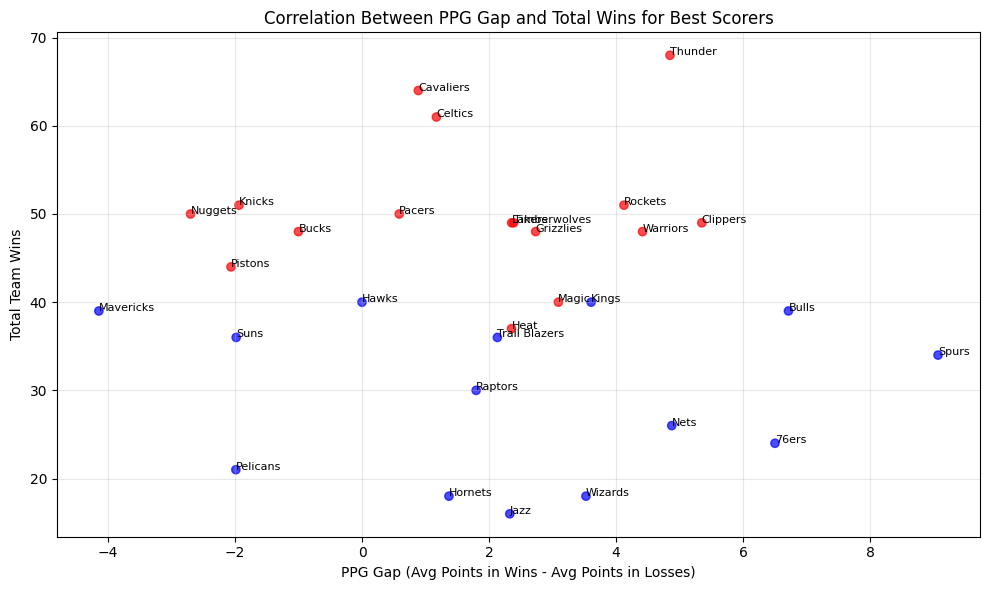

In [23]:
# create a plot using team's best scorer ppg_gap to see if there's a correlation between the gap and wins and label the dots with the teams
plot_df = topTeamScorers[topTeamScorers['season'] == '2024-2025'].copy()
plot_df = plot_df.merge(game_wins, left_on=['team', 'season'], right_on=['playerteamName', 'season'], how='left')
playoff_teams = ['Nuggets', 'Heat', 'Bucks', 'Celtics', 'Cavaliers', 'Warriors', 'Lakers', 'Knicks', 'Clippers', 'Grizzlies','Magic','Pistons','Thunder','Pacers','Timberwolves','Rockets']
plot_df['is_playoff_team'] = plot_df['team'].apply(lambda x: x in playoff_teams)
# color playoff teams differently
plot_df['color'] = plot_df['is_playoff_team'].apply(lambda x: 'red' if x else 'blue')
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['ppg_gap'], plot_df['total_team_wins'], c=plot_df['color'], alpha=0.7)
for i, team in enumerate(plot_df['team']):
    plt.text(plot_df['ppg_gap'].iloc[i], plot_df['total_team_wins'].iloc[i], team, fontsize=8)
plt.xlabel("PPG Gap (Avg Points in Wins - Avg Points in Losses)")
plt.ylabel("Total Team Wins")
plt.title("Correlation Between PPG Gap and Total Wins for Best Scorers")
plt.grid(alpha=0.3)
plt.tight_layout()

In [24]:
# Build a logistic regression model to predict win or loss based on points scored, points per game, and average points per win and loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# Prepare the data for modeling
model_df = season_player_stats.dropna(subset=['avg_points_per_win', 'avg_points_per_loss'])
X = model_df[['points_per_game', 'avg_points_per_win', 'avg_points_per_loss']]
y = model_df['total_team_wins'] > (model_df['player_games_played'] / 2)  # Binary target: win more than half the games
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)
# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")

KeyError: 'total_team_wins'